In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython
import pandas as pd

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Now, lets look at if pupil size is responding to how much bigger losses are than equivalent gains

In [24]:
behavior = load_behavioral_data(min_RT = 0.2)
behavior = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/behavioral_data_SQ_break.csv")
behavior = behavior[["sub", "trial", "RT", "sq_break", "condition", "accept"]]
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]

In [ ]:
data["loss_gain"] = np.log(data["loss"] / data["gain"])

In [25]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(broom.mixed)

First, we examine if there are differences in the interaction between stimuli and pupil size. 

In [26]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ accept*condition + RT*condition  + (1| sub) + (-1 + RT|sub) + (-1 + accept|sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00225759 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00236127 (tol = 0.002, component 1)


In [25]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ poly(loss_gain, 2)*condition + RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain|sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00658915 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00568536 (tol = 0.002, component 1)


In [27]:
results["p.value"] = false_discovery_control(results["p.value"], method = "by")
results = results.rename(columns={"p.value": "p_value"})

In [28]:
# From this, all I want to look is at the pvalues that are significant
results = results.query("p_value < 0.05 & term.str.contains('conditionequalRange')")

In [29]:
results

,effect,term,estimate,std.error,statistic,df,p_value,conf.low,conf.high,timebin
71,fixed,accept:conditionequalRange,0.294315,0.085427,3.445201,41.018147,0.030406,0.121793,0.466837,1.419355
77,fixed,accept:conditionequalRange,0.344143,0.091562,3.758576,41.381357,0.014606,0.159281,0.529004,1.548387
83,fixed,accept:conditionequalRange,0.383290,0.096693,3.963978,42.065261,0.008267,0.188164,0.578415,1.677419
89,fixed,accept:conditionequalRange,0.404967,0.100539,4.027938,43.081575,0.007272,0.202221,0.607712,1.806452
95,fixed,accept:conditionequalRange,0.425515,0.106214,4.006215,43.787162,0.007337,0.211426,0.639605,1.935484
101,fixed,accept:conditionequalRange,0.449036,0.109598,4.097115,44.279571,0.005959,0.228195,0.669877,2.064516
107,fixed,accept:conditionequalRange,0.467225,0.108537,4.304770,44.561812,0.004257,0.248562,0.685888,2.193548
113,fixed,accept:conditionequalRange,0.457491,0.107240,4.266061,44.448652,0.004257,0.241425,0.673557,2.322581
119,fixed,accept:conditionequalRange,0.431061,0.103453,4.166727,44.328386,0.005262,0.222608,0.639513,2.451613
125,fixed,accept:conditionequalRange,0.403398,0.098333,4.102366,44.567680,0.005959,0.205292,0.601503,2.580645


In [30]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ accept + RT + (1| sub) + (-1 + RT|sub) + (-1 + accept | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ accept + RT + (1| sub) + (-1 + RT|sub) + (-1 + accept | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00329639 (tol = 0.002, component 1)


In [32]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ poly(loss_gain, 2) + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ poly(loss_gain, 2) + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_gain | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00686687 (tol = 0.002, component 1)


In [33]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

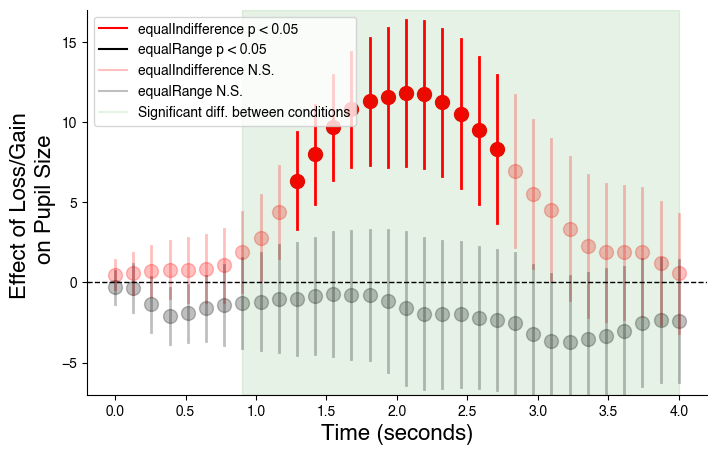

In [34]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'poly(loss_gain, 2)1'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Loss/Gain \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
if linear_term.shape[0] > 0:
    ax.axvspan(min(linear_term), max(linear_term), color="green", alpha=0.1)
ax.set_ylim(-7, 17)
plt.show()

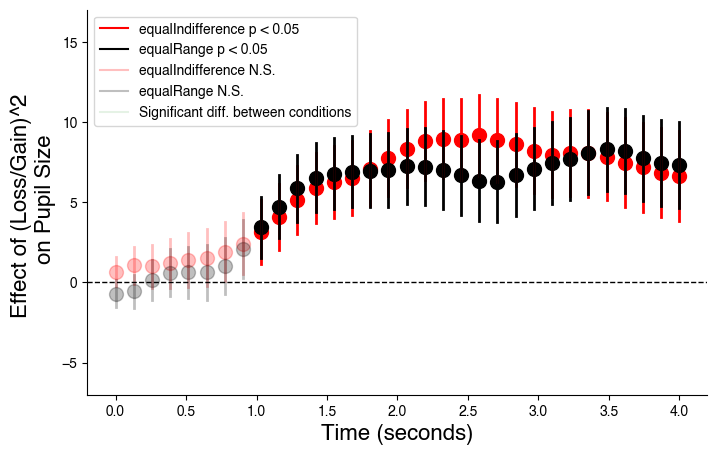

In [12]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'poly(loss_gain, 2)2'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of (Loss/Gain)^2 \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
ax.set_ylim(-7, 17)
plt.show()

In [32]:
results_individual

,effect,term,estimate,std.error,statistic,df,p.value,conf.low,conf.high,condition,timebin
1,fixed,(Intercept),0.011131,0.019952,0.557880,404.580918,5.772348e-01,-0.028091,0.050352,equalIndifference,0.0
2,fixed,accept,-0.016162,0.012154,-1.329787,3391.078125,1.836778e-01,-0.039992,0.007668,equalIndifference,0.0
3,fixed,RT,-0.004964,0.009482,-0.523496,1006.066854,6.007445e-01,-0.023570,0.013643,equalIndifference,0.0
4,fixed,(Intercept),0.002785,0.015764,0.176687,3716.657777,8.597638e-01,-0.028121,0.033691,equalRange,0.0
5,fixed,accept,0.000710,0.011593,0.061264,53.060753,9.513793e-01,-0.022542,0.023963,equalRange,0.0
...,...,...,...,...,...,...,...,...,...,...,...
188,fixed,accept,-0.004273,0.049085,-0.087052,25.365898,9.313136e-01,-0.105292,0.096746,equalIndifference,4.0
189,fixed,RT,0.430959,0.052923,8.143192,16.960855,2.911745e-07,0.319283,0.542636,equalIndifference,4.0
190,fixed,(Intercept),-0.670154,0.068890,-9.727829,81.932317,2.600232e-15,-0.807200,-0.533107,equalRange,4.0
191,fixed,accept,0.130377,0.044498,2.929966,20.989932,8.004623e-03,0.037836,0.222918,equalRange,4.0


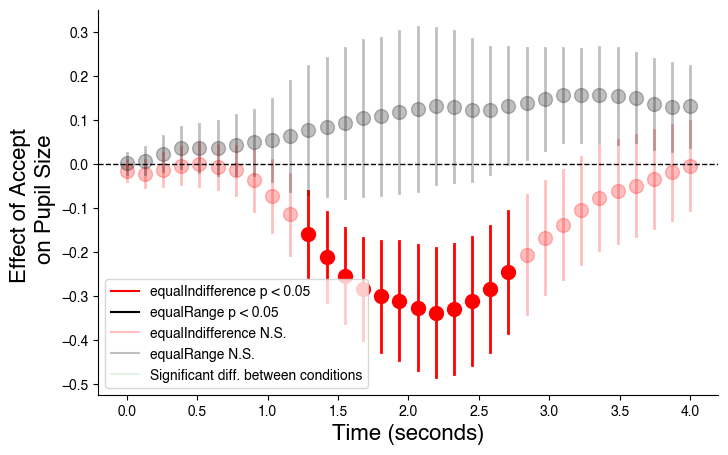

In [35]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'accept'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Accept \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
# ax.set_ylim(-7, 17)
plt.show()

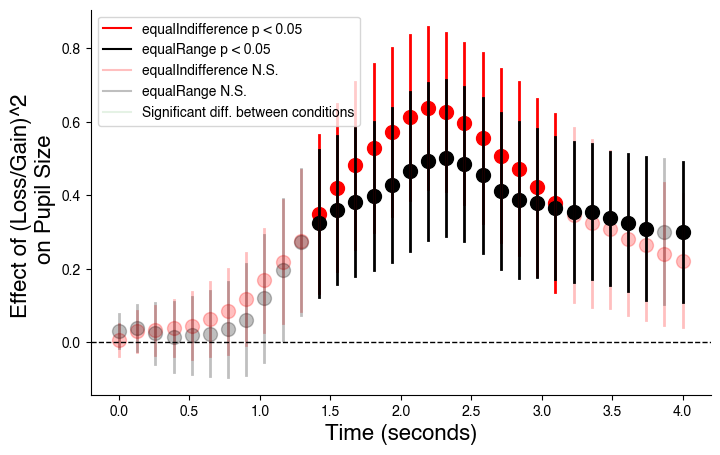

In [23]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'sq_break'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of (Loss/Gain)^2 \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if loss_gain_timebin.shape[0] > 0:
#     ax.axvspan(min(loss_gain_timebin), max(loss_gain_timebin), color="red", alpha=0.1)
# ax.set_ylim(-7, 17)
plt.show()